In [ ]:

import os
from PIL import Image
folder_path = "test_data"


In [11]:
!pip install torch torchvision transformers pillow


In [12]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel


In [13]:
pip install ipywidgets


  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)


In [14]:
# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
#function to load images

def load_images(folder_path):
    images = []
    image_paths = []

    for file in os.listdir(folder_path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, file)
            image = Image.open(img_path).convert("RGB")  # Convert to RGB mode
            images.append(image)
            image_paths.append(img_path)

    return images, image_paths

folder_path = "test_data"
images, image_paths = load_images(folder_path)


In [ ]:
#function to extract image features
def extract_image_features(images):
    image_inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**image_inputs)

    return image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize embeddings

image_features = extract_image_features(images)


In [ ]:
#function to encode text query  
def encode_text_query(text_query):
    text_inputs = processor(text=[text_query], return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)

    return text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize embeddings


In [18]:
def retrieve_top_k_images(text_query, image_features, image_paths, k=5):
    text_embedding = encode_text_query(text_query)  # Get text embedding
    similarities = (image_features @ text_embedding.T).squeeze(1)  # Compute cosine similarity
    top_k_indices = similarities.argsort(descending=True)[:k]  # Get top-K matches

    top_k_images = [image_paths[i] for i in top_k_indices]
    return top_k_images


Top-K Matching images:


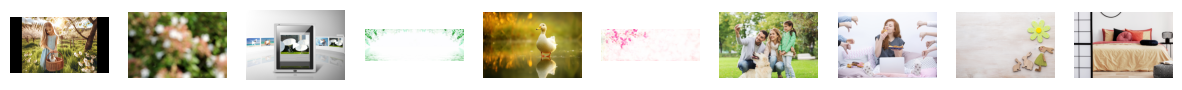

In [ ]:
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Step 1: Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Step 2: Define the folder path and load images
folder_path = "test_data"

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

images = []
for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    image = Image.open(img_path).convert("RGB")
    images.append(image)

image_inputs = processor(images=images, return_tensors="pt", padding=True)

# Step 3: Generate image embeddings
with torch.no_grad():
    image_features = model.get_image_features(**image_inputs)
image_embeddings = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

# Step 4: Define function to get top-K images
def retrieve_top_k_images(text_query, image_embeddings, image_paths, k=10):
    # Preprocess the text query
    text_inputs = processor(text=text_query, return_tensors="pt", padding=True)

    # Generate text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
    text_embedding = text_features / text_features.norm(p=2, dim=-1, keepdim=True)  # Normalize embedding

    # Compute cosine similarity between text and image embeddings
    similarities = cosine_similarity(text_embedding.cpu().numpy(), image_embeddings.cpu().numpy())

    # Get indices of top-k similar images
    top_k_indices = np.argsort(similarities[0])[::-1][:k]

    # Return the top-k image file names
    top_k_images = [image_paths[i] for i in top_k_indices]
    return top_k_images

# Step 5: Display the images
def display_images(top_k_images, folder_path):
    num_images = len(top_k_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(top_k_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  
    plt.show()

query = "retrieve images with cats" 
k = 10
top_k_images = retrieve_top_k_images(query, image_embeddings, image_files, k=k)

print("Top-K Matching images:")
display_images(top_k_images, folder_path)